In [1]:
import cv2
import tifffile
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
vidpath = "multi_test.tif"
image_dir = "../inputs/images"
fullpath = f"{image_dir}/{vidpath}"

# Notes
1. Be wary of OME-TIFF, just convert to TIFF beforehand
2. **time**, **color**, **width**, **height**

# Goal: Track cells
1. For each color channel
    1. Tweak histogram
    2. Threshold
    3. Segment
    4. Measure

In [3]:
vid = tifffile.imread(fullpath)
frames, colors, width, height = vid.shape
ch1 = vid[:,0,:,:]
ch2 = vid[:,1,:,:]
ch3 = vid[:,2,:,:]
ch4 = vid[:,3,:,:]

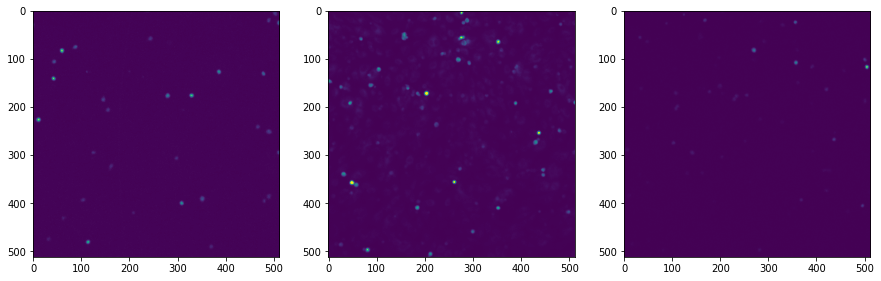

In [4]:
fig, ax = plt.subplots(1,3,figsize=(15,10))
ax[0].imshow(ch1[0])
ax[1].imshow(ch2[0])
ax[2].imshow(ch3[0])
plt.show()

In [63]:
import skimage.exposure
from skimage.filters import threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import disk
from skimage.segmentation import felzenszwalb


# Notes/Issues
1. Downsample & scale to 255
    + We are not interested in quantification, just object tracking. Can throw away precision.
2. Equalize histogram
    + Need to figure out kernel size, and eq method to be used programatically.
3. Otsu Thresh + Binarization
    + This seems to be working fine at the moment.
4. Morpho
    + Need to use morpho transforms to get rid of specks and close up gaps.
5. Segmentation


# Pipeline

In [64]:
ch1t0 = ch1[0]
d1 = downsample(ch1t0)
eqd = skimage.exposure.equalize_adapthist(d1, kernel_size =7)
thresh = threshold_otsu(eqd)
binary = eqd > thresh
selem = disk(2)
opened = opening(binary, selem)
segments = felzenszwalb(opened, scale=3.0, sigma=0.95, min_size=5)

# Visualization

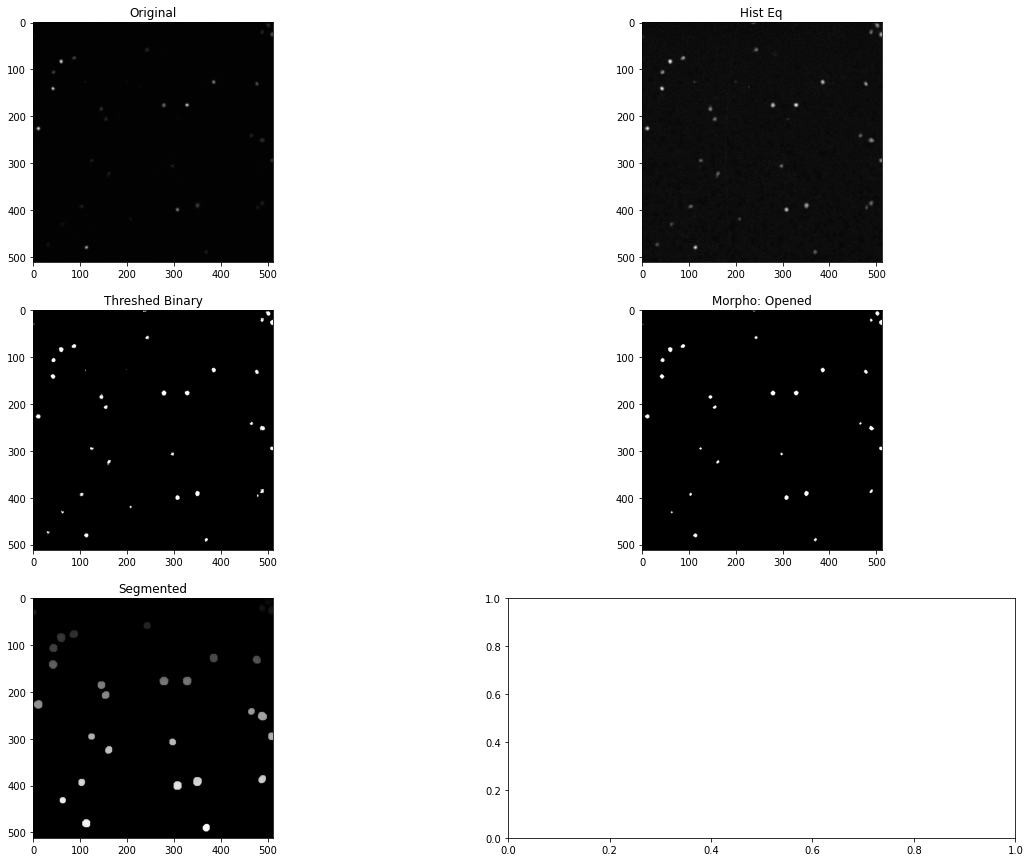

In [66]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
          '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

fig,ax = plt.subplots(3,2, figsize=(20,15))
ax = ax.ravel()
ax[0].imshow(d1, cmap="gray")
ax[0].set_title("Original")

ax[1].imshow(eqd, cmap="gray")
ax[1].set_title("Hist Eq")

ax[2].imshow(binary, cmap="gray")
ax[2].set_title("Threshed Binary")

ax[3].imshow(opened, cmap="gray")
ax[3].set_title("Morpho: Opened")

ax[4].imshow(segments, cmap="gray")
ax[4].set_title("Segmented")
plt.show()

# Previous stuff

In [2]:
vidpath = "test.tif"
vid = tifffile.imread(vidpath)
frames,width,height = vid.shape

# Helper Functions

In [23]:
def downsample(img):
    norm = img/img.max()
    down = (norm*255).astype(np.uint8)
    return down
def downsample_time_series(df):
    down = [downsample(frame) for frame in df]
    return np.array(down)
def frame_sub(df):
    frames = len(df)
    sub = [df[i+1] - frame for i,frame in enumerate(df) if i+1 < frames]   
    return np.array(sub)
def estimate_bg(vid):
    med_bg = np.median(vid,axis=0)
    return med_bg
def dashview(images,max_cols=4):
    ''' Returns subplots in grid for inspection'''
    plots = len(images)    
    cols = plots
    if plots >= max_cols:
        cols = max_cols
    rows = ((plots-1)//max_cols) + 1
 
    # print(f"Generating {plots} [{rows} x {cols}] plots...")
        
    fig,axs = plt.subplots(ncols=cols,nrows=rows,
                           figsize=(20,20),squeeze=False,tight_layout=True)

    r,c = axs.shape
    for i in range(r):
        for j in range(c):
            flat_counter = (i*c)+j
            if flat_counter < plots:
                # print(f"Generating {flat_counter}")
                axs[i,j].imshow(images[flat_counter],cmap="gray")
            else:
                # print(f"{flat_counter} empty")
                axs[i,j].set_axis_off()

In [4]:
from skimage.filters import gaussian

In [5]:
gray = downsample_time_series(vid)

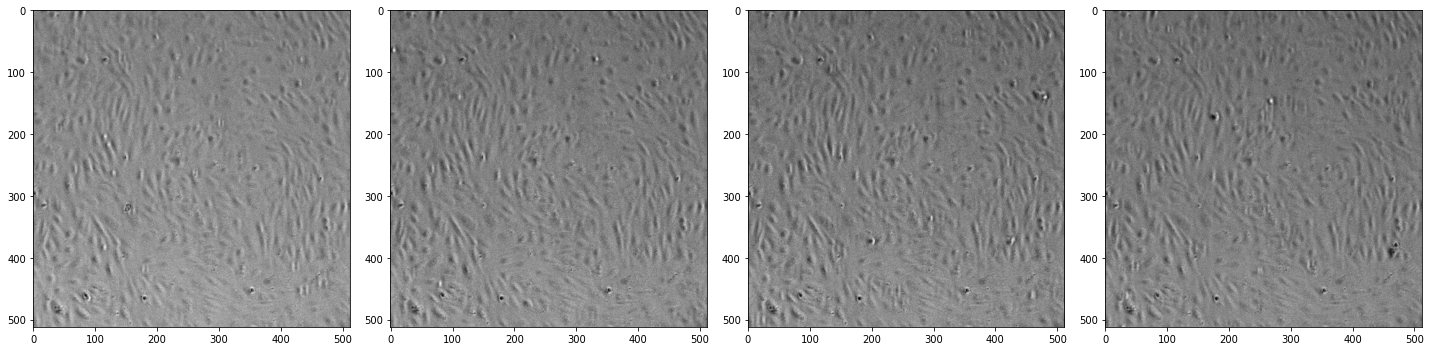

In [6]:
dashview(gray[:10*4:10])

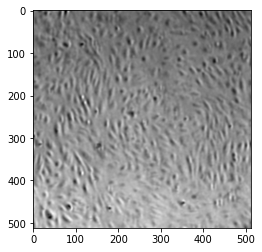

In [7]:
blurred = gaussian(gray[0],sigma=2)
plt.imshow(blurred,cmap="gray")
plt.show()

# Using first frame of video as background

## Issues:
+ Doesn't seem to work, in fact it creates a consistent background image across all frames

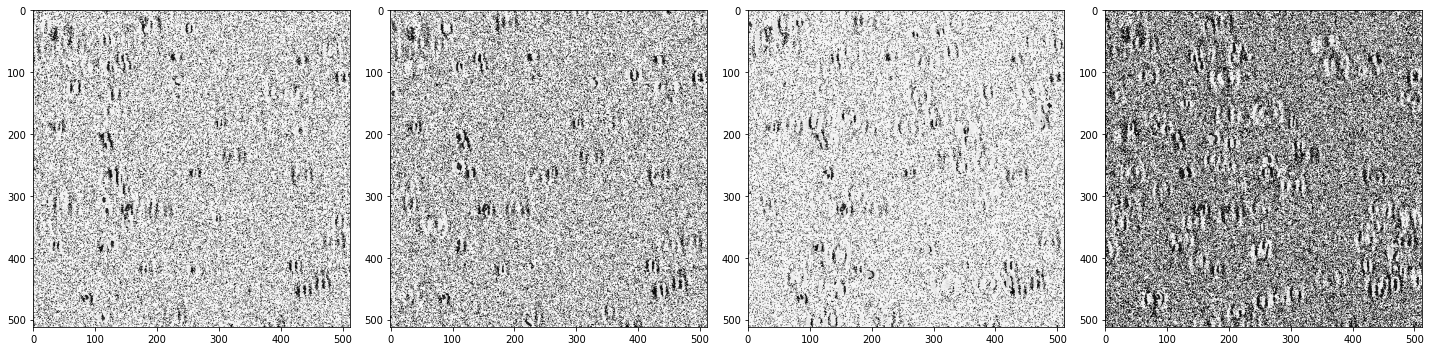

In [65]:
bg_sub = np.array([(frame - frame0).astype(np.uint8) for frame in test8])

dashview(bg_sub[1:10*4+1:10])

In [71]:
bg_sub.mean()

213.0362424507141

# Using median frame as background

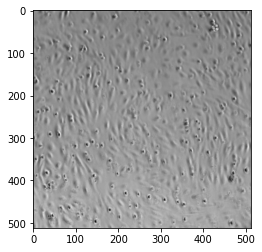

In [34]:
bg = estimate_bg(test8)
bg8 = bg.astype(np.uint8)
plt.imshow(bg,cmap="gray")
plt.show()

## Results

+ This doesn't seem to be doing much? I feel like the images are too bright, I think something went wrong here.

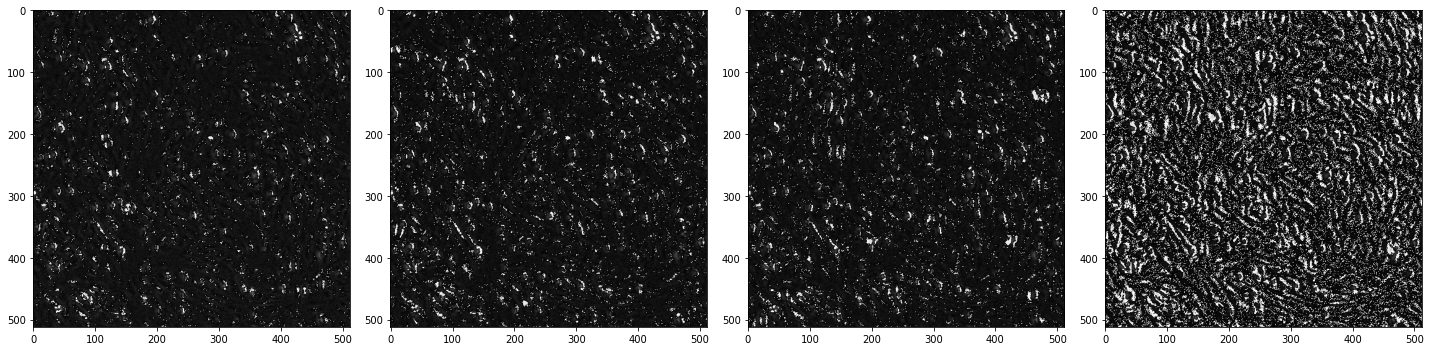

In [35]:
med_sub = [frame - bg8 for frame in test8]
dashview(med_sub[:10*4:10])

In [36]:
med_sub[0].dtype

dtype('uint8')

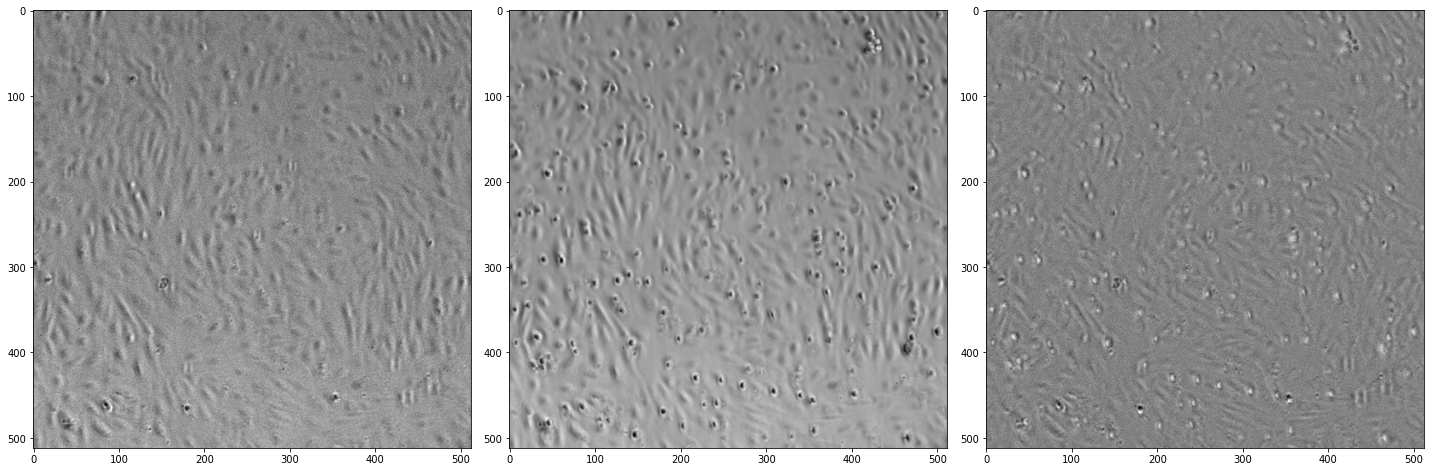

In [22]:
panel = [test8[0],bg,med_sub[0]]
panel_not = [np.bitwise_not(f) for f in panel]
dashview(panel)

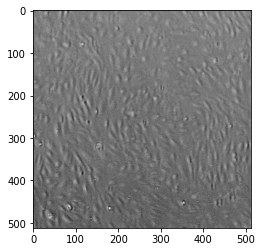

In [23]:
inv = np.bitwise_not(test8[0])
plt.imshow(inv, cmap="gray")
plt.show()